In [4]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.insert(1, '..\\..\\Instruments\\network\\RS_Signal_Generator')
sys.path.insert(2, '..\\..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\..\\Instruments\\QuickSyn')
sys.path.insert(4, '..\\..\\HDF5')
sys.path.insert(5, '..\\')
import Tools

import RS_SMA100B
import FSL_0010
from Card_Class import PXIe5170R
from HDF5 import *

In [2]:
QSyn_port       = 'COM31'
SG_ip           = '192.168.40.15'                                   # Set IP address of the device
Card_Name       = 'PXI1Slot3'

fsl             = FSL_0010.FSL10_synthesizer(device_address = QSyn_port)
sGen            = RS_SMA100B.SMA100B(ip = SG_ip)
pxie            = PXIe5170R(resource_name = Card_Name)

FSL_0010:	Connection successful!
SMA100B:	Connection successful!
PXIe_5170R:    Connection successful!


In [3]:
pulse_f_min     = 3.010e9
# pulse_f_max		= 

amplitude		    = -6                                               # Set the amplitude of the signal in dBm
# amp_max			= 


sample_rate     = 250e6                                             # Maximum Value: 250.0e6
k = 4                                                               # coefficiente per prendere k*1000 punti 
																	# con la scheda, dunque devo aumentare la pulse width e period
pulse_period    = k * 1e-6                                          # 4e-6 con 250e6 dà 1000 punti
num_pts         = int(sample_rate * pulse_period)                   # min 5ns                             
pulse_delay     = 0

percent         = 5
pulse_width     = pulse_period * (1 - percent/100)                  # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')


# parameters for the Acquisition Card
pxie.voltage_range      = 0.5
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = num_pts
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6


# FSL-0010
fsl_freq = 3
fsl.set_frequency(fsl_freq) # GHz

'FSL_0010: Frequency set to 3 GHz.'

In [19]:
trig_CH = 3
I_CH	= 2
Q_CH	= 0

channels = {'I'			: None, 
			'Q'			: 0,
			'trigger'	: 3}


print(fsl.set_output('ON'))
pxie.open(trigger_channel = channels['trigger'])

pula        = np.arange(pulse_f_min, pulse_f_min + 0.010e9, 0.010e9)

data_dict   = {'power_(dBm)': amplitude, 'power_(mV peak)': round(Tools.dBm_to_mVpk(amplitude),3), 'freqs': {}}
counter     = 1

digits_f = "{:0"+str(len(str(len(pula))))+"d}"
sGen.RF_lvl_ampl(amplitude)

for i, pul in enumerate(pula):

	sGen.RF_freq(pul) 
	sGen.pul_state(1)
	sGen.RF_state(1)
	waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
	dict = {'input_freq_(Hz)'	: pul}
	for key, value in channels.items():
		if key == 'trigger' or value is None:
			continue
		dict[key] = np.array(waveforms[value].samples.tolist())
		FT = np.abs(np.fft.fft(dict[key]))
		N = len(dict[key])
		T = 1/sample_rate
		freqs = np.fft.fftfreq(N,T) 
		dict[key+'_freq'] = round(freqs[np.argmax(FT[:N // 2])], 3)
		dict[key+'_power'] = round(Tools.get_avg_power(y = dict[key], toggle_plot = False, sample_rate = sample_rate)['mean']*1e3, 3)
	sGen.pul_state(0)
	sGen.RF_state(0)


	print(f'\rf{digits_f.format(i)}	: {int(counter*100/len(pula))} %\n', end='')
	sys.stdout.flush()
	counter += 1
	data_dict['freqs'][f'f{digits_f.format(i)}'] = dict
print(fsl.set_output('OFF'))
# plt.clf()
# plt.plot(freqs[:N // 2],FT[:N // 2])
# plt.show()

RF set to ON
f0	: 100 %
RF set to OFF


In [21]:
pxie.close()

PXIe_5170R: Session closed


In [20]:
# SAVE DATA ON HDF5 FILE
filename = f'Mixer_1237_{fsl_freq}GHz.h5'
if os.path.exists(filename):
  os.remove(filename)
save_dict_to_hdf5(data_dict, filename)

## La scelta del tappo influiva leggermente sull'ampiezza letta.

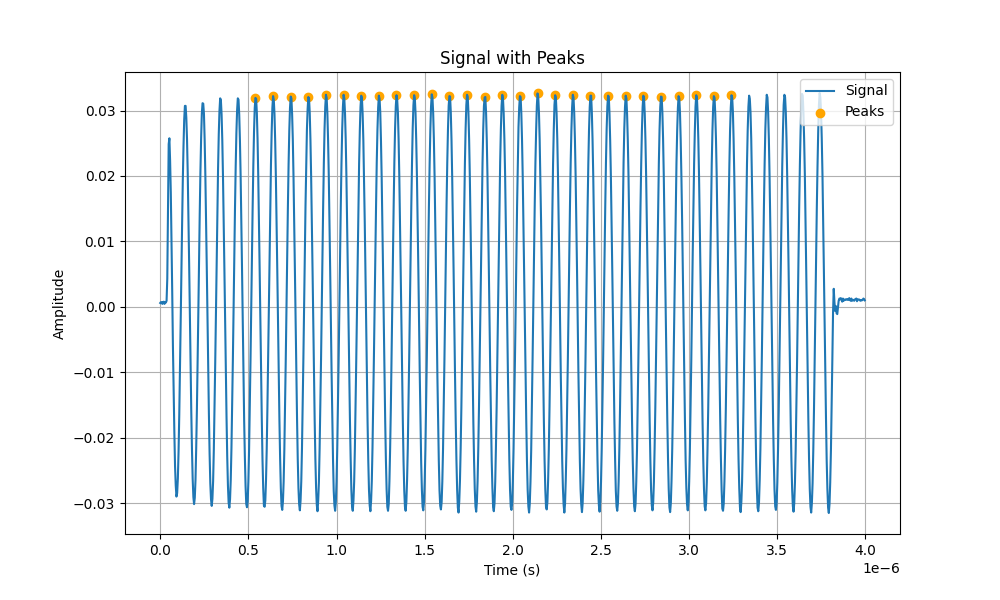

32.286892546575736
158.4893192461113
Attenuazione su Q:  0.7962834801729523


In [10]:
data = load_hdf5_to_dict('Mixer_1135_5GHz.h5')

wave = np.array(data['freqs']['f00']['Q'])

#print(I)
a = (Tools.get_avg_power(wave)['mean'])*1e3
b = Tools.dBm_to_mVpk(data['power_(dBm)'])

print(a)
print(b)

print('Attenuazione su Q: ', (1 - a/b) )